# Prunning Reviewers for Labelled Texts
This notebook will look at the effects of pruning reviewers based on several different criteria

## Import Packages and Set Directory

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('/home/jovyan/shared/2020_06_10_bad_reviewer')

## Load the Various DataFrames
There are a bunch of dataframes here:
#### labelled_txts - The target group of texts with author id and full text
#### texts_df - All the texts
#### data_view_df - Information about the peer reviews (old)
#### reviewer_df - Aggregate information about the reviewers
#### cleared_submissions - Submissions which have been cleared
#### submissions_df - All submissions
#### reviews_df - Information about the peer reviews (new)

In [3]:
reviewer_df = pd.read_csv('results/reviewer_agg_stats.csv', index_col=[0])
cleared_submissions = pd.read_csv('bin/cleared_submissions.csv')
submissions_df = pd.read_csv('bin/submissions_df.csv', index_col=[0])
reviews_df = pd.read_csv('bin/reviews_df.csv', index_col = [0])

# Rename the columns to disambiguate whether the id represents a reviewer or an author
submissions_df = submissions_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})
reviewer_df = reviewer_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
reviews_df = reviews_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
cleared_submissions = cleared_submissions.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})

# Get the author id into reviews_df
reviews_df = pd.merge(reviews_df, cleared_submissions[['peer_submission_id', 'uva_peer_assignments_user_id_author']], on='peer_submission_id', how="left")
# Note that authors could only be found for 864,073 out of the 1,059,044 reviews.
reviews_df.count()

peer_review_id                                             1084657
uva_peer_assignments_user_id_reviewer                      1084657
peer_review_created_ts                                     1084657
peer_submission_id                                         1084657
peer_assignment_review_schema_part_prompt_score             929706
peer_assignment_review_schema_part_option_score             929706
peer_assignment_review_schema_part_prompt_free_response    1084640
peer_review_part_free_response_text                        1059044
uva_peer_assignments_user_id_author                         864073
dtype: int64

## Get rid of any duplicate submissions from labelled_txts
Of 27909 submissions, 22903 were non-duplicates

In [5]:
# Find duplicate essays
print(len(submissions_df))
submissions_df['is_duplicate'] = submissions_df.duplicated(subset=['text'], keep=False)
texts = submissions_df[submissions_df['is_duplicate']==False][['uva_peer_assignments_user_id_author', 'text']]

texts

27909


,uva_peer_assignments_user_id_author,text
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,Reflection – visualization\n\nChallenge &...
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,Assignment :\n\n1. Challenge: Describe your ch...
2,00030b378ea62d60a177113b7854eb26cc29e1a9,VISUALIZATION\n\nChallenge I am part of the...
3,000458f7d47a0b6414f9146258829170ae3ed6a9,The main item is usually the focal point of th...
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,Storytelling is when narratives people tell ab...
...,...,...
28342,fff43ee22d85efffada33d73f953c0d814d90290,Peter Vogt - Design Thinking Reflection - Lear...
28343,fff56a1858c62540bd76bad23db07a2fbfa963fe,STORYTELLING AS A TOOL FOR STRATEGIC CHANGES\n...
28344,fff7364558963fb9fa218f2fa08d5d2767992207,Junio 2019 Storytelling Jose Vergara\n\nChalle...
28345,fffa6add42713b8b1e2a5158616f780997bbda49,Reflexion - Mind Mapping\n\nChallenge & Select...


## Get number of words for each of the labelled texts and add variance to reviewer_df

In [6]:
# Get number of words for the labelled texts
texts['num_words'] = texts.apply(lambda row: len(row['text'].split()), axis=1)

# Get reviewer variance
reviewer_df['total_variance'] = reviewer_df['total_sd']**2
texts

,uva_peer_assignments_user_id_author,text,num_words
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,Reflection – visualization\n\nChallenge &...,583
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,Assignment :\n\n1. Challenge: Describe your ch...,1003
2,00030b378ea62d60a177113b7854eb26cc29e1a9,VISUALIZATION\n\nChallenge I am part of the...,627
3,000458f7d47a0b6414f9146258829170ae3ed6a9,The main item is usually the focal point of th...,215
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,Storytelling is when narratives people tell ab...,1070
...,...,...,...
28342,fff43ee22d85efffada33d73f953c0d814d90290,Peter Vogt - Design Thinking Reflection - Lear...,496
28343,fff56a1858c62540bd76bad23db07a2fbfa963fe,STORYTELLING AS A TOOL FOR STRATEGIC CHANGES\n...,779
28344,fff7364558963fb9fa218f2fa08d5d2767992207,Junio 2019 Storytelling Jose Vergara\n\nChalle...,802
28345,fffa6add42713b8b1e2a5158616f780997bbda49,Reflexion - Mind Mapping\n\nChallenge & Select...,807


## Exploratory Data Analysis

## A function to look at the effect of pruning reviewers 
It takes a beginning, and end, and an interval and returns a dictionary with four lists, minimum feature, number of reviews retained, number of authors retained, and correlation between score and word count. Please note, it requires that you define a function in advance called pruneReviewers which tells it which metric to prune reviewers by.

In [7]:
def pruneReviewersData(beginning, end, interval):
    # Initialize the stats dictionary
    stats_dict = {'minimum_feature':[], 'num_reviews':[], 'score_correlation':[], 'num_authors':[]}

    labelled_data = texts.merge(reviews_df, on='uva_peer_assignments_user_id_author', how='left')
    print(len(texts), len(set(labelled_data['uva_peer_assignments_user_id_author'])))

    # essay_scores contains, author id, reviewer id, submission id, and the sum score for each review
    essay_scores = labelled_data.groupby(['uva_peer_assignments_user_id_reviewer', 'peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'sum'}).reset_index()
    # check to make sure it looks valid
    print('checking for non-null values\n' , essay_scores.count(), sep='')
    print('num of reviews:', len(essay_scores))
    print('num of authors:', essay_scores['uva_peer_assignments_user_id_author'].nunique())

    for i in np.arange(beginning,end,interval):
        good_reviewers = pruneReviewers(i)
        # Merge essay scores with good reviewers and keep only reviews by good reviewers
        essay_scores_good_reviewers = good_reviewers.merge(essay_scores, on='uva_peer_assignments_user_id_reviewer', how='right')
        essay_scores_good_only = essay_scores_good_reviewers[essay_scores_good_reviewers['good_reviewer'] == True]
        # Create a dataframe of submission ids of submissions reviewed by at least two good reviewers
        good_reviewers_df = essay_scores_good_only.groupby('peer_submission_id').agg({'good_reviewer':'sum'}).reset_index()
        good_reviewers_df = good_reviewers_df[good_reviewers_df['good_reviewer'] >= 2].rename(columns={'good_reviewer':'num_reviews'})
        # Merge essay scores with good reviewers in order to remove submissions with less than two good reviewers
        essay_scores_good_labelled = essay_scores_good_only.merge(good_reviewers_df, on='peer_submission_id', how='right')
        # Collect average scores for each submission
        essay_scores_final = essay_scores_good_labelled.groupby(['peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'mean'}).reset_index()
        corr_df = essay_scores_final[['uva_peer_assignments_user_id_author',
                                  'peer_assignment_review_schema_part_option_score']].drop_duplicates().merge(texts[['uva_peer_assignments_user_id_author', 
                                                                                                                 'num_words']].drop_duplicates(), on='uva_peer_assignments_user_id_author', how='left')
        # Calculate statistics
        stats_dict['minimum_feature'].append(i)
        stats_dict['num_reviews'].append(len(essay_scores_good_labelled))
        stats_dict['num_authors'].append(len(good_reviewers_df))
        stats_dict['score_correlation'].append(corr_df[['peer_assignment_review_schema_part_option_score','num_words']].corr().iloc[0,1])
        
    return stats_dict

## Prune Reviewers Based on Variance

In [8]:
# Define function to mark reviewers based on a given variance threshold
def pruneReviewers(variance_threshold):
    good_reviewers_df = reviewer_df[reviewer_df['total_variance']>=variance_threshold][['uva_peer_assignments_user_id_reviewer']]
    good_reviewers_df['good_reviewer'] = True
    return good_reviewers_df

stats_dict = pruneReviewersData(0, 20, 0.1)

22903 22903
checking for non-null values
uva_peer_assignments_user_id_reviewer              77313
peer_submission_id                                 77313
uva_peer_assignments_user_id_author                77313
peer_assignment_review_schema_part_option_score    77313
dtype: int64
num of reviews: 77313
num of authors: 22892


### Explore the data

In [12]:
df = pd.DataFrame.from_dict(stats_dict)
df[df['minimum_feature'] < 2].sort_values(by='score_correlation', ascending=False)

,minimum_feature,num_reviews,score_correlation,num_authors
19,1.9,23820,0.326122,10036
18,1.8,24357,0.322074,10222
17,1.7,24490,0.321319,10271
15,1.5,29138,0.318444,11973
16,1.6,25084,0.318381,10486
14,1.4,29609,0.317120,12132
13,1.3,29817,0.314744,12208
12,1.2,30197,0.314609,12346
11,1.1,30700,0.314214,12515
10,1.0,31159,0.313499,12683


### Graph

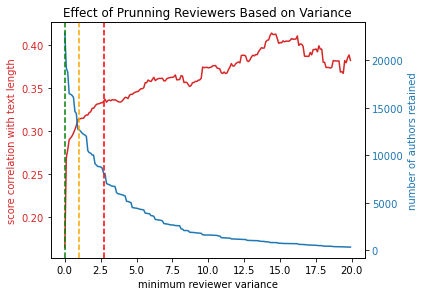

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = stats_dict['minimum_feature']
data1 = stats_dict['score_correlation']
data2 = stats_dict['num_authors']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('minimum reviewer variance')
ax1.set_ylabel('score correlation with text length', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of authors retained', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axvline(x=0.0001, color='green', linestyle='dashed')
plt.axvline(x=1, color='orange', linestyle='dashed')
plt.axvline(x=2.75, color='red', linestyle='dashed')
plt.title('Effect of Prunning Reviewers Based on Variance')
plt.show()


## Pruning Based on TTR

In [18]:
# Define function to mark reviewers based on a given variance threshold
def pruneReviewers(ttr_threshold):
    good_reviewers_df = reviewer_df[reviewer_df['total_ttr']>=ttr_threshold][['uva_peer_assignments_user_id_reviewer']]
    good_reviewers_df['good_reviewer'] = True
    return good_reviewers_df

stats_dict = pruneReviewersData(0, 1, 0.001)

22903 22903
checking for non-null values
uva_peer_assignments_user_id_reviewer              77313
peer_submission_id                                 77313
uva_peer_assignments_user_id_author                77313
peer_assignment_review_schema_part_option_score    77313
dtype: int64
num of reviews: 77313
num of authors: 22892


### Explore Data

In [17]:
pd.DataFrame.from_dict(stats_dict).sort_values(by='score_correlation', ascending=False).head(5)

,minimum_feature,num_reviews,score_correlation,num_authors
405,0.405,26984,0.316988,10971
396,0.396,28528,0.316793,11495
395,0.395,28700,0.316475,11550
401,0.401,27690,0.316202,11213
406,0.406,26807,0.316061,10911


### Make a Graph

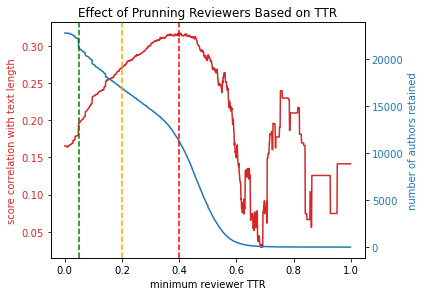

In [19]:
import numpy as np
import matplotlib.pyplot as plt

t = stats_dict['minimum_feature']
data1 = stats_dict['score_correlation']
data2 = stats_dict['num_authors']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('minimum reviewer TTR')
ax1.set_ylabel('score correlation with text length', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of authors retained', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.axvline(x=0.05, color='green', linestyle='dashed')
plt.axvline(x=0.2, color='orange', linestyle='dashed')
plt.axvline(x=0.4, color='red', linestyle='dashed')

plt.title('Effect of Prunning Reviewers Based on TTR')
plt.show()

## Looking at Combined Variance > 0 and TTR

In [20]:
def pruneReviewers(ttr_threshold):
    good_reviewers_df = reviewer_df[(reviewer_df['total_ttr']>=ttr_threshold)|reviewer_df['total_variance'] >0][['uva_peer_assignments_user_id_reviewer']]
    good_reviewers_df['good_reviewer'] = True
    return good_reviewers_df

stats_dict = pruneReviewersData(0,1,0.001)


22903 22903
checking for non-null values
uva_peer_assignments_user_id_reviewer              77313
peer_submission_id                                 77313
uva_peer_assignments_user_id_author                77313
peer_assignment_review_schema_part_option_score    77313
dtype: int64
num of reviews: 77313
num of authors: 22892


### Look at Data

In [99]:
score_df = pd.DataFrame.from_dict(stats_dict)
score_df[score_df['minimum_feature']==0.45]

,minimum_feature,num_reviews,score_correlation,num_authors
450,0.45,9813,0.269259,2569


### Graph

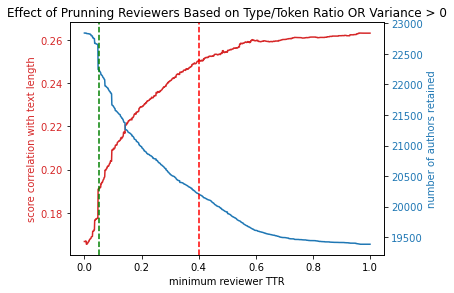

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = stats_dict['minimum_feature']
data1 = stats_dict['score_correlation']
data2 = stats_dict['num_authors']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('minimum reviewer TTR')
ax1.set_ylabel('score correlation with text length', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of authors retained', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.axvline(x=0.05, color='green', linestyle='dashed')
plt.axvline(x=0.4, color='red', linestyle='dashed')

plt.title('Effect of Prunning Reviewers Based on Type/Token Ratio OR Variance > 0')
plt.show()

In [25]:
def pruneReviewers(variance_threshold):
    good_reviewers_df = reviewer_df[(reviewer_df['total_ttr']>=0.4)|(reviewer_df['total_variance'] > variance_threshold)][['uva_peer_assignments_user_id_reviewer']]
    good_reviewers_df['good_reviewer'] = True
    return good_reviewers_df

stats_dict = pruneReviewersData(0,20,0.1)


22903 22903
checking for non-null values
uva_peer_assignments_user_id_reviewer              77313
peer_submission_id                                 77313
uva_peer_assignments_user_id_author                77313
peer_assignment_review_schema_part_option_score    77313
dtype: int64
num of reviews: 77313
num of authors: 22892


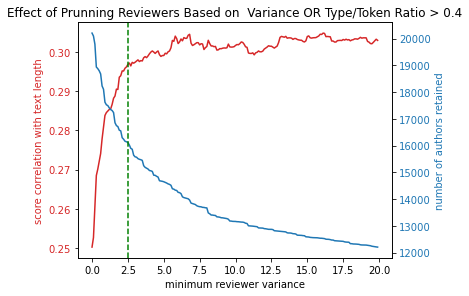

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = stats_dict['minimum_feature']
data1 = stats_dict['score_correlation']
data2 = stats_dict['num_authors']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('minimum reviewer variance')
ax1.set_ylabel('score correlation with text length', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('number of authors retained', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.axvline(x=02.5, color='green', linestyle='dashed')

plt.title('Effect of Prunning Reviewers Based on  Variance OR Type/Token Ratio > 0.4')
plt.show()

In [17]:
pd.set_option('display.max_rows', 500)
pd.DataFrame.from_dict(stats_dict).head(10)

,minimum_ttr,num_reviews,score_correlation,num_authors
0,0.000,14268,0.200626,2972
1,0.001,14268,0.200626,2972
2,0.002,14268,0.200626,2972
3,0.003,14268,0.200626,2972
4,0.004,14247,0.200664,2972
5,0.005,14247,0.200664,2972
6,0.006,14227,0.201126,2972
7,0.007,14209,0.201337,2972
8,0.008,14208,0.201343,2972
9,0.009,14203,0.201026,2971


## Everything below this is just tinkering around

In [18]:
# Tinkering around

stats_dict = {'minimum_sd':[], 'num_reviews':[], 'score_correlation':[], 'num_authors':[]}

good_reviewers = pruneReviewers(2)
essay_scores = data_view_df.groupby(['uva_peer_assignments_user_id_reviewer', 'peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'sum'}).reset_index()
essay_scores = labelled_txts.merge(essay_scores, on='uva_peer_assignments_user_id_author', how='left')
essay_scores = good_reviewers.merge(essay_scores, on='uva_peer_assignments_user_id_reviewer', how='right')
essay_scores = essay_scores[essay_scores['good_reviewer'] == True]
    
good_reviewers_df = essay_scores.groupby('peer_submission_id').agg({'good_reviewer':'sum'}).reset_index()
good_reviewers_df = good_reviewers_df[good_reviewers_df['good_reviewer'] >= 2].rename(columns={'good_reviewer':'num_reviews'})
good_reviewers_df
essay_scores = essay_scores.merge(good_reviewers_df, on='peer_submission_id', how='right')
essay_scores

essay_scores_final = essay_scores.groupby(['peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'mean'}).reset_index()

stats_dict['minimum_sd'].append(1)
stats_dict['num_reviews'].append(len(essay_scores[essay_scores['good_reviewer']==True]))
stats_dict['num_authors'].append(len(good_reviewers_df))
stats_dict['score_correlation'].append(essay_scores[['peer_assignment_review_schema_part_option_score','num_words']].corr().iloc[0,1])

print(stats_dict)

{'minimum_sd': [1], 'num_reviews': [10086], 'score_correlation': [0.16287516987671583], 'num_authors': [2729]}


In [35]:
import seaborn as sns
bad_reviewers = reviewer_df[reviewer_df['total_variance'] == 0]['total_mean'].value_counts().rename_axis('score').reset_index(name='count')
print('total reviewers:', len(reviewer_df))
print('bad reviewers:', len(reviewer_df[reviewer_df['total_variance'] == 0]))
print('proportion:', len(reviewer_df[reviewer_df['total_variance'] == 0])/len(reviewer_df))


sns.barplot(data=bad_reviewers,
            x='score',
            y='count')

total reviewers: 41242
bad reviewers: 12731
proportion: 0.30869017021482953


ValueError: Could not interpret input 'score'

<AxesSubplot:xlabel='total_mean', ylabel='Count'>

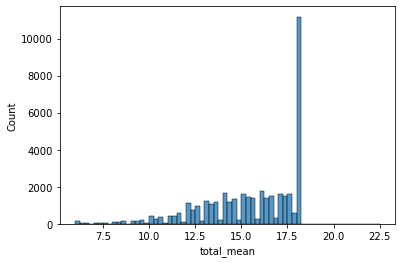

In [60]:
sns.histplot(data=reviewer_df, x='total_mean')

In [61]:
reviewer_df[reviewer_df['total_mean']>18]

,uva_peer_assignments_user_id_reviewer,num_reviews,criteria_mean,criteria_sd,total_mean,total_sd,total_tokens,total_types,total_ttr,response_tokens,response_types,response_ttr,num_responses,solo_reviews,response_ratio,total_variance
2825,121ade9d078639b186c58f9cd2aaced28dc6dc75,5.0,3.000000,0.000000,22.500000,7.794229,153,67,0.437908,4.371429,4.085714,0.969674,35,0,1.0,60.750000
22476,8b94f695dd791bb62a1a0e14f0a7943640e99ddc,4.0,2.555556,0.562722,20.666667,8.055364,461,192,0.416486,16.464286,15.285714,0.953887,28,0,1.0,64.888889


In [57]:
def describe(feature):
    print(feature,len(reviewer_df), round(reviewer_df[feature].mean(),2), round(reviewer_df[feature].std(),2), 
          round(reviewer_df[feature].min(),2), round(reviewer_df[feature].max(),2),sep=',')

describe('criteria_mean')
describe('total_mean')
describe('total_variance')
describe('total_ttr')

criteria_mean,41242,2.57,0.43,1.0,3.0
total_mean,41242,15.43,2.59,6.0,22.5
total_variance,41242,4.33,7.25,0.0,64.89
total_ttr,41242,0.33,0.22,0.0,1.0
